In [311]:
%matplotlib inline
# Common Imports
import numpy as np
#Pandas for creating dataframes
import pandas as pd
#Sklearn
from sklearn import preprocessing
#K-means clustering algo
from sklearn.cluster import KMeans
#OS moduled for file oprations
import os
#CSV module
import csv
#Plotting
import matplotlib.pyplot as plt
import shutil

In [312]:
#Base Folder Paths
base_folder_name = 'converted'
test_folder_name = 'test3'
base_path = os.path.join(base_folder_name, test_folder_name)
#Normal Sample and cluster paths
sample_dir_name = 'samp'
sample_path = os.path.join(base_path, sample_dir_name)
#If sample folder exist
if os.path.isdir(sample_path):
    #Test and Train data Folders
    train_path = os.path.join(base_path, sample_dir_name+'_train')
    os.makedirs(train_path, exist_ok=True)
    test_path = os.path.join(base_path, sample_dir_name+'_test')
    os.makedirs(test_path, exist_ok=True)
    
    train_cluster_path = os.path.join(train_path, 'cluster')
    test_cluster_path = os.path.join(test_path, 'cluster')
    os.makedirs(train_cluster_path, exist_ok=True)
    os.makedirs(test_cluster_path, exist_ok=True)
#Defining features
features = [6,17] #(TCP:6, UDP:17)    

In [313]:
def get_feature_dataframe(sample_file, features):
        df = pd.read_csv(sample_file, index_col=0)
        #Filter Columns
        df = df[['ip.dst', 'ip.proto', 'sniff_timestamp', 'sample']]
        #Remove null destinations
        df = df[df['ip.dst'].notnull()]
        #Rename Columns
        df.columns = ['ip', 'protocol', 'time_stamp', 'sample']
        #Get count for each ip
        df = df.groupby(['ip', 'protocol']).size().unstack().fillna(0).astype(int)
        #Drop row for given IP
        df = filter_ip(df, '147.32.84.165')
        #Select TCP and UDP as only fetures (TCP:6, UDP:17)
        df = df[features]
        if(set(df.columns) != set(features)):
            print(df.columns, features)
            non_columns = set(features) - set(df.columns)
            for c in non_columns:
                df.insert(loc=features.index(c), column=c, value=0)
        return df, sample_file

In [314]:
def filter_ip(df, ip_addr):
    with open(os.path.join(base_path,"filtered_ip_feture_vector"), "a+") as f:
        df.loc[ip_addr].to_csv(f, header=False)
    df = df.drop([ip_addr])
    return df    

In [315]:
filenames = sorted(glob.glob(os.path.join(sample_path,'*')),  key=os.path.getmtime)
df, sample_file = get_feature_dataframe(filenames[0], features)

In [316]:
df.head()

protocol,6,17
ip,,
147.32.80.9,0,14
147.32.84.255,0,50
195.88.191.59,2,0
224.0.0.22,0,0
239.255.255.250,0,6


In [317]:
def create_train_test(sample_path, features):
    count = 0; train_dfs = []; test_dfs = []
    filenames = sorted(glob.glob(os.path.join(sample_path,'*')),  key=os.path.getmtime)
    file_count = len(filenames)
    #Split train and test Train size 80% of data and 20% (1/5 th) is test
    reminder = file_count%5
    #Number of files to be combined to form one train/test data
    merge_count = int((file_count - reminder) / 5)
    train_files = filenames[:merge_count*4]
    test_files = filenames[merge_count*4:]
    #print(train_files)
    #print(test_files)
    for i, filename in enumerate(train_files, 1):
        if count == 0:
            df, sample_file = get_feature_dataframe(filename, features)
            count += 1
        else:
            temp_df, sample_file = get_feature_dataframe(filename, features)
            df = df.append(temp_df)
            count += 1
        if count == merge_count:
            df = df.groupby(df.index).sum() #Combine data of same IP address
            train_dfs.append(df)
            count = 0
    
    for i, filename in enumerate(test_files, 1):
        if count == 0:
            df, sample_file = get_feature_dataframe(filename, features)
            count += 1
        else:
            temp_df, sample_file = get_feature_dataframe(filename, features)
            df = df.append(temp_df)
            count += 1
        if count == merge_count:
            df = df.groupby(df.index).sum() #Combine data of same IP address
            test_dfs.append(df)       
    return train_dfs, test_dfs

In [318]:
train_dfs, test_dfs = create_train_test(sample_path, features)

In [319]:
#train_dfs[0]

In [320]:
#Write train and test data to file
train_files = []
for i, df in enumerate(train_dfs, 1):
    train_file = os.path.join(train_path,str(i))
    df.to_csv(train_file)
    train_files.append(train_file)
test_files = []    
for i, df in enumerate(test_dfs, 1):
    test_file = os.path.join(test_path,str(i))
    df.to_csv(test_file)
    test_files.append(test_file)

In [321]:
from sklearn.cluster import KMeans
#Find optimal number of clusters for k-means clustering using elbow method.
def elbow_method(X_trans):
    elbow_count = 0
    range_val = 10
    nc = range(1, range_val)
    kmeans = [KMeans(n_clusters=i) for i in nc]
    score = [kmeans[i].fit(X_trans).score(X_trans) for i in range(len(kmeans))]
    total_diff = abs(score[0] - score[len(score) -1])
    for i in range(range_val - 2):
        percent_diff = abs(score[i] - score[i+1])/total_diff
        if percent_diff < 0.01:
            opt_clust_count = i
            break
#     plt.plot(nc,score)
#     plt.xlabel('Number of Clusters')
#     plt.ylabel('Score')
#     plt.title('Elbow Curve')
#     plt.show()
    return opt_clust_count

In [322]:
#Apply elbow method on all the samples and get their mean
def get_optimal_cluster_count(df_list):
    elbow_vals = []
    for df in df_list:
        X = df.values
        #Create scaling
        scaler = preprocessing.StandardScaler().fit(X)
        #Transform Traning data
        X_trans = scaler.transform(X)
        elbow = elbow_method(X_trans)
        elbow_vals.append(elbow)
    return int(np.floor(np.mean(elbow_vals)))

In [323]:
cluster_count = get_optimal_cluster_count(train_dfs)

/home/arpit/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [324]:
cluster_count

4

In [325]:
# Calculating Eigenvectors and eigenvalues of Cov matirx
def PCA_component_analysis(X_std):
    mean_vec = np.mean(X_std, axis=0)
    cov_mat = np.cov(X_std.T)
    eig_vals, eig_vecs = np.linalg.eig(cov_mat)

    # Create a list of (eigenvalue, eigenvector) tuples
    eig_pairs = [ (np.abs(eig_vals[i]),eig_vecs[:,i]) for i in range(len(eig_vals))]

    # # Sort from high to low
    eig_pairs.sort(key = lambda x: x[0], reverse= True)

    # Calculation of Explained Variance from the eigenvalues
    tot = sum(eig_vals)
    var_exp = [(i/tot)*100 for i in sorted(eig_vals, reverse=True)] # Individual explained variance
    cum_var_exp = np.cumsum(var_exp) # Cumulative explained variance

    # PLOT OUT THE EXPLAINED VARIANCES SUPERIMPOSED 
    plt.figure(figsize=(10, 5))
    plt.bar(range(9), var_exp, alpha=0.3333, align='center', label='individual explained variance', color = 'g')
    plt.step(range(9), cum_var_exp, where='mid',label='cumulative explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='best')
    plt.show()

In [326]:
def get_kmeans_centroid(feature_df, cluster_count):
    """ 
    X: feature vector 
    cluster_count: Number of clusters to be used for k-means
    """
    df_centroid = {}
    X = feature_df.values
    #Create scaling
    scaler = preprocessing.StandardScaler().fit(X)
    #Transform Traning data
    X_trans = scaler.transform(X)
    #Data Fitting using K-means
    kmeans = KMeans(n_clusters=cluster_count)
    kmeans.fit(X_trans)
    #Insert cluster center to its corrosposnding dataframe each dataframe.
    #Dataframe 0 contain all the clusters centers associated with 0th cluster
    first = True
    for i in range(kmeans.cluster_centers_.shape[0]):
        s = pd.Series(kmeans.cluster_centers_[i], index=feature_df.columns)
        if(first):
            df_centroid = pd.DataFrame(columns=feature_df.columns)
            first = False
        df_centroid = df_centroid.append(s,ignore_index=True)
    return df_centroid

In [327]:
#Find the median of all the centroid which will be better estimate of the centroid for all future k-means clustering
def kmeans_common_create_centroids(sample_frames, features, cluster_count, centroid_filename, features_filename):
    """
    sample_frames: list of feature vector datafames
    centroid_filename: File in which centroid has to be stored for future analyasis
    features_filename: File in which feature list will be stored
    """
    df_concat = pd.DataFrame(columns=features)
    for df in sample_frames:
        #Run kmeans and get centroid
        df_centroid = get_kmeans_centroid(df, cluster_count)
        #Create list of centroids
        df_concat = df_concat.append(df_centroid)
    centroids = []
    #Find median for each centroid and store them in file
    for c in range(cluster_count):
        med = np.median(df_concat.loc[c], axis=0) # e.g. df_concat.loc[0] is df of clister 0
        centroids.append(med)
    #Save centroids and features in files for future use
    np.savetxt(os.path.join(base_path, centroid_filename), np.asarray(centroids), delimiter=",")
    np.savetxt(os.path.join(base_path, features_filename), np.asarray(list(features)), delimiter=",")
    return centroids, features

In [328]:
#File to store centroids
centroid_filename = 'centroids.csv'
#File to store feature list
features_filename = 'features.csv'
#Call to find median of centroid
kmeans_common_create_centroids(train_dfs, features, cluster_count, centroid_filename, features_filename)

/home/arpit/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


([array([-0.05484402, -0.07208976]),
  array([ 15.21015284,  -0.12229021]),
  array([ -0.141429  ,  20.45665207]),
  array([-0.11294475,  5.36018905])],
 [6, 17])

In [329]:
#Get centroids and feature from the files
def read_centroid_features(centroid_filename, features_filename):
    centroids = np.genfromtxt(os.path.join(base_path,centroid_filename), delimiter=',')
    features = np.genfromtxt(os.path.join(base_path,features_filename), delimiter=',')
    return centroids, features

In [330]:
from sklearn.decomposition import PCA
def draw_clusters(X, centroids, kmeans):
    #Use PCA component analysis for visuals
    if X.shape[1] > 2:
        reduced_X = PCA(n_components=2).fit_transform(X)
    else:
        reduced_X = X
   
    # Step size of the mesh. Decrease to increase the quality of the VQ.
    h = .01     # point in the mesh [x_min, x_max]x[y_min, y_max].

    # Plot the decision boundary. For that, we will assign a color to each
    x_min, x_max = reduced_X[:, 0].min() - 1, reduced_X[:, 0].max() + 1
    y_min, y_max = reduced_X[:, 1].min() - 1, reduced_X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Obtain labels for each point in mesh. Use last trained model.
    Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.imshow(Z, interpolation='nearest',
               extent=(xx.min(), xx.max(), yy.min(), yy.max()),
               cmap=plt.cm.Paired,
               aspect='auto', origin='lower')   
    #Plot the data points (PCA reduced components)
    plt.plot(reduced_X[:,0],reduced_X[:,1],  'k.', markersize=3) 
    plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=169, linewidths=3, color='w', zorder=10)
    plt.title('K-means clustering with (PCA-reduced data)')
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xticks(())
    plt.yticks(())
    plt.show()

In [331]:
def kmeans_clustering(feature_df, centroids):
    X = feature_df.values
    #Create scaling
    scaler = preprocessing.StandardScaler().fit(X)
    #Transform Traning data
    X_trans = scaler.transform(X)
    #k means clustering using provided centroids 
    kmeans = KMeans(n_clusters=centroids.shape[0], init=centroids)
    clusters = kmeans.fit_predict(X_trans)
    #Plot clusters and data using PCA component analysis
    draw_clusters(X_trans, centroids, kmeans)
    #Getting the labels/clusters and distances of each IP from centroid
    cluster_df = pd.DataFrame({'cluster': kmeans.labels_})
    #Attaching label and distance to existing df and write new dataframe to file
    df = pd.concat([feature_df.reset_index(), cluster_df], axis=1).set_index('ip')
    return df

/home/arpit/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/arpit/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:896: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)


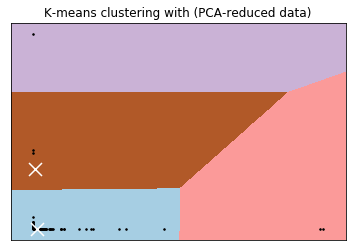

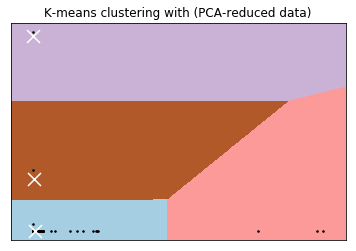

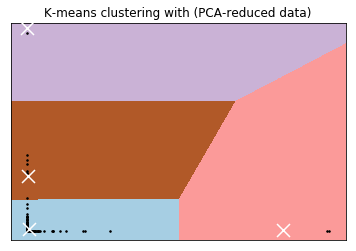

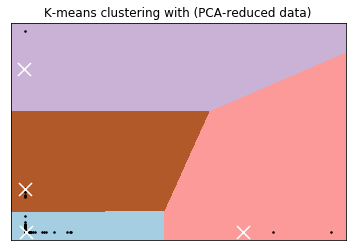

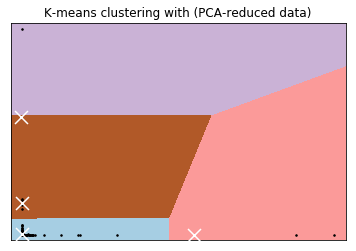

In [332]:
#Cluster all the samples and store them
centroids, features = read_centroid_features(centroid_filename, features_filename)
for i, train_df in enumerate(train_dfs):
    clustered_df = kmeans_clustering(train_df, centroids)
    clustered_df.to_csv(os.path.join(train_cluster_path,str(i+1)))
for i, test_df in enumerate(test_dfs):
    clustered_df = kmeans_clustering(test_df, centroids)
    clustered_df.to_csv(os.path.join(test_cluster_path,str(i+1)))    

In [218]:
print(centroids)

[[ -0.08534303  -0.05546653]
 [ -0.11294475  20.45665207]
 [ 14.88156061  -0.10197929]
 [ -0.07684554   2.36481097]]


In [333]:
def get_combined_df(cluster_path):
    cluster_dict = dict()
    filenames = sorted(glob.glob(os.path.join(cluster_path,'*')),  key=os.path.getmtime)
    first = True
    for filename in filenames:
        if first:
            df = pd.read_csv(filename, index_col=0)
            first = False
        else:
            temp_df = pd.read_csv(filename, index_col=0)
            df = df.append(temp_df) 
    df = df.reset_index().set_index(['ip'])
    return df

In [466]:
dfc = get_combined_df(train_cluster_path)

In [467]:
duplicates = dfc.loc[dfc.index.duplicated()]

In [468]:
nonduplicates = dfc.loc[~dfc.index.duplicated()]

In [469]:
duplicates.shape, nonduplicates.shape, dfc.shape

((670, 3), (1734, 3), (2404, 3))

In [485]:
nonduplicates.sum(axis=1).shape

(1734,)

In [470]:
dfc.loc['109.200.240.44']

,6,17,cluster
ip,,,
109.200.240.44,2,0,0
109.200.240.44,4,0,0


In [471]:
df = dfc.loc['109.200.240.44']

In [473]:
packet_count = duplicates[['6','17']].groupby('ip').mean().sum(axis=1).astype('int64')

In [474]:
packet_count.head()

ip
109.200.239.148     4
109.200.240.44      4
109.70.26.36       26
111.253.202.95      6
111.88.1.3          2
dtype: int64

In [477]:
cluster = duplicates[['cluster']].groupby('ip').median().astype('int64')

In [482]:
cluster.shape, packet_count.shape

((475, 1), (475,))

In [493]:
combineddf = pd.concat([packet_count, cluster], axis=1)

In [417]:
dm['cluster'] = pd.Series([0,0,0,0,0,0,0,20], index=dm.index)

In [418]:
dm

,cluster
ip,
109.200.240.44,0
109.200.240.44,0
109.200.240.44,0
109.200.240.44,0
109.200.240.44,0
109.200.240.44,0
109.200.240.44,0
109.200.240.44,20


In [419]:
dm[['cluster']].groupby('ip').median()

,cluster
ip,
109.200.240.44,0


In [411]:
int(1.5)

1

In [219]:
#For a given IP address find how many time a given cluster it was assigned to.
from itertools import groupby
def get_IP_cluster_count_dict(cluster_path):    
    ip_dict = dict()
    filenames = glob.glob(os.path.join(cluster_path,'*'))
    for filename in filenames:
        with open(filename, newline='') as csvfile:
            reader = csv.DictReader(csvfile)
            for row in reader:
                if row['ip'] in ip_dict:
                    #print(row['ip'],ip_dict[row['ip']])
                    ip_dict[row['ip']] = ip_dict[row['ip']] + [row['cluster']]
                else:
                    ip_dict[row['ip']] = [row['cluster']]
    #Find how many time IP was assigned to a given cluster
    ip_cluster_dict = dict()
    for key, value in ip_dict.items():
        ip_cluster_dict[key] = {k: len(list(group)) for k, group in groupby(value)}
    return ip_cluster_dict

In [220]:
ip_cluster_dict = get_IP_cluster_count_dict(cluster_path)

In [221]:
#ip_cluster_dict

In [222]:
def tag_ip_with_cluster(ip_cluster_dict):
    df = pd.DataFrame(columns=['ip','cluster'])
    for ip, clusters in ip_cluster_dict.items():
        if len(clusters) == 1:
            clust = list(clusters.keys())[0]
        else:
            mx = 0
            clust = 0
            for cluster, count in clusters.items():
                if count > mx:
                    mx = count
                    clust = cluster
        df = df.append(pd.Series([ip, clust], index=df.columns), ignore_index=True)
    df = df.set_index('ip')
    return df

In [223]:
df = tag_ip_with_cluster(ip_cluster_dict)
tag_filename = 'ip_cluster_tag_test'
tag_file = os.path.join(base_path,tag_filename)
df.to_csv(tag_file)

In [224]:
df.head()

,cluster
ip,
101.0.32.121,0
109.200.239.148,0
109.206.161.3,0
109.206.162.162,0
109.234.156.34,0


In [225]:
#Create feature vector corrosponding to each cluster. 
#This feature vector would be used to define boundray using One Class SVM for the cluster.
def get_clusters_feature_vectors(cluster_path):
    cluster_dict = dict()
    filenames = sorted(glob.glob(os.path.join(cluster_path,'*')),  key=os.path.getmtime)
    first = True
    for filename in filenames:
        if first:
            df = pd.read_csv(filename, index_col=0)
            first = False
        else:
            temp_df = pd.read_csv(filename, index_col=0)
            df = df.append(temp_df) 
    df = df.reset_index().set_index(['cluster','ip'])
    clusters = df.index.get_level_values(0).unique()
    for c in clusters:
        cluster_dict[c] = df.loc[c].iloc[:,:-1].values
    return cluster_dict

In [236]:
train_tag_filename = 'ip_cluster_tag_train'
train_tag_file = os.path.join(base_path,train_tag_filename)
train_df = df.from_csv(train_tag_file)
test_tag_filename = 'ip_cluster_tag_test'
test_tag_file = os.path.join(base_path,test_tag_filename)
test_df = df.from_csv(test_tag_file)

In [257]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3086 entries, 1.22.16.143 to 95.64.43.62
Data columns (total 1 columns):
cluster    3086 non-null int64
dtypes: int64(1)
memory usage: 128.2+ KB


In [238]:
result = pd.merge(train_df, test_df, left_index=True, right_index=True, how='right')

In [268]:
r = result.dropna()
r = r.astype(int)

In [270]:
r.head()

,cluster_x,cluster_y
ip,,
109.200.239.148,0,0
109.206.161.3,0,0
109.206.162.162,0,0
109.234.156.34,0,0
109.235.49.72,0,0


In [279]:
#r.iloc[:,0].tolist()

In [280]:
actual_clusters = r.iloc[:,0].tolist()
predicted_clusters = r.iloc[:,1].tolist()

In [282]:
import numpy as np
from scipy.misc import comb

def rand_index_score(actual_clusters, predicted_clusters):
    tp_plus_fp = comb(np.bincount(actual_clusters), 2).sum()
    tp_plus_fn = comb(np.bincount(predicted_clusters), 2).sum()
    A = np.c_[(actual_clusters, predicted_clusters)]
    tp = sum(comb(np.bincount(A[A[:, 0] == i, 1]), 2).sum()
             for i in set(actual_clusters))
    fp = tp_plus_fp - tp
    fn = tp_plus_fn - tp
    tn = comb(len(A), 2) - tp - fp - fn
    ri =  (tp + tn) / (tp + fp + fn + tn)
#     precision = tp / tp_plus_fp
#     recall = tp / tp_plus_fn
    print(ri, precision, recall)
    return ri, precision, recall

In [283]:
rand_index_score(actual_clusters, predicted_clusters)

0.994729971104 0.996023887487 0.998664054504


(0.99472997110442285, 0.99602388748741644, 0.99866405450410467)

In [55]:
def plot_outlier_detecton(X_train, clf, title):
    
    xx, yy = np.meshgrid(np.linspace(-5, 5, 500), np.linspace(-5, 5, 500))
    
    # plot the levels lines and the points
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    plt.title("Outlier Detection:" + str(title))
    plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.PuBu)
    a = plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='darkred')
    #plt.contourf(xx, yy, Z, levels=[0, Z.max()], colors='palevioletred')
    
    s = 40
    b1 = plt.scatter(X_train[:, 0], X_train[:, 1], c='white', s=s, edgecolors='k')
    plt.axis('tight')
    plt.xlim((-5, 5))
    plt.ylim((-5, 5))
    plt.legend([a.collections[0], b1],
           ["learned frontier", "training observations"],
           loc="upper left")
    plt.show()

In [56]:
#SKlearn SVM
from sklearn import svm
from sklearn.neighbors import LocalOutlierFactor
def one_class_svm(feature_vector, cluster):
    X_train = feature_vector
    #Get scaler
    scaler = preprocessing.StandardScaler().fit(X_train)
    #Transform Traning data
    X_trans = scaler.transform(X_train)
    # fit the model
    clf = svm.OneClassSVM(nu=0.01, kernel="rbf", gamma=0.1)
    clf.fit(X_trans)
    clf.name = 'svm'
    #Plot the graph
    title = ' Cluster '+ str(cluster)
    plot_outlier_detecton(X_trans, clf, title)
    return clf, scaler

/home/arpit/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


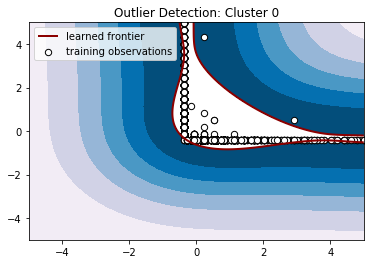

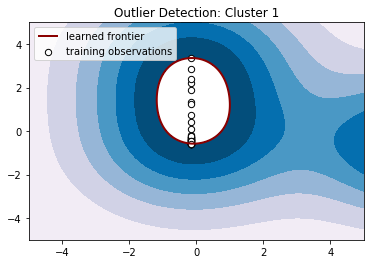

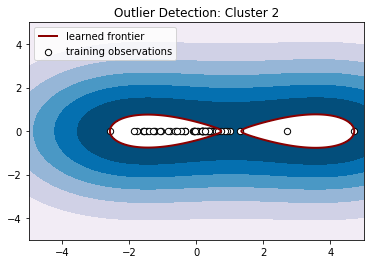

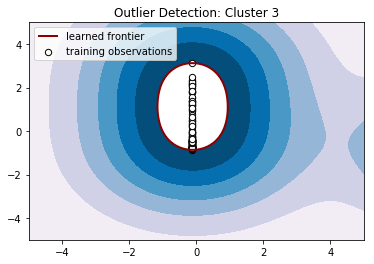

In [57]:
cluster_feature_dict = get_clusters_feature_vectors(cluster_path)
clf_dict = dict()
scaler_dict = dict()
for cluster, df in cluster_feature_dict.items():
    clf_dict[cluster], scaler_dict[cluster] = one_class_svm(df, cluster)

In [58]:
cluster_feature_dict[0]

array([[ 2,  0],
       [ 2,  0],
       [ 6,  0],
       ..., 
       [18,  0],
       [ 2,  0],
       [30,  0]])

In [112]:
#Predict for the give destination if it is normal or not
X_test = [[658,0]]#[[1491,18]]
X_test_tran = scaler_dict[0].transform(X_test)
clf_dict[0].predict(X_test_tran)

array([1])

svm
0.731601893977 -7.32636224249


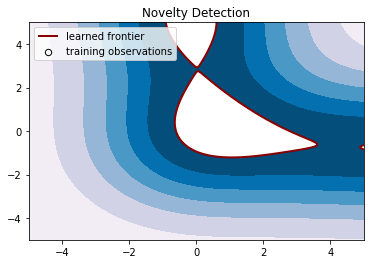

In [113]:
plot_outlier_detecton(X_test_tran, clf_dict[0])